In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import spacy
import string
from wordcloud import WordCloud, STOPWORDS

## Loading Train and test data

In [46]:
train_data_log= pd.read_csv('./SAMPLE_DATA/labeled-encoded-data-samples/may_jun_jul_2021.csv')


### Read Train 

In [32]:
train_data_log.head()

length  params_number  return_code   size  upper_cases  lower_cases  \
0      98              1          301    606           10           67   
1      98              1          404    291           10           67   
2      48              1          200  24768            7           19   
3      52              1          200    847            7           18   
4      14              1          200  12844            7            0   

   special_chars  url_depth  label  \
0              7          9      0   
1              7          9      0   
2              7          3      0   
3              7          4      0   
4              1          2      0   

                                            log_line  
0  23.228.109.147 - - [01/May/2021:02:39:43 -0700...  
1  23.228.109.147 - - [01/May/2021:02:39:43 -0700...  
2  207.46.13.53 - - [01/May/2021:02:44:34 -0700] ...  
3  114.119.141.53 - - [01/May/2021:02:46:43 -0700...  
4  106.38.241.178 - - [01/May/2021:02:47:47 -0700...

In [47]:
print('There are {} rows and {} columns in train'.format(train_data_log.shape[0],train_data_log.shape[1]))


There are 113447 rows and 10 columns in train


### Class Distribution
##### 
Before we begin with anything else,let's check the class distribution.There are only two classes 0 and 1.


Text(0, 0.5, 'samples')

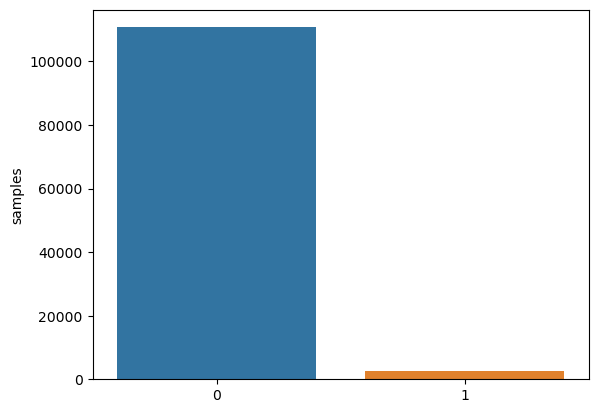

In [34]:
x=train_data_log.label.value_counts()
sns.barplot(x=x.index,y=x)
plt.gca().set_ylabel('samples')



In [35]:
# get only values counts for label 1 because label 0 is the majority class
numbers_samples=train_data_log.label.value_counts()[1] 
print(numbers_samples)

2689


In [36]:

df_safe = train_data_log[train_data_log.label==0].sample(numbers_samples, random_state=2024)
df_suspecious = train_data_log[train_data_log.label==1].sample(numbers_samples, random_state=2024)
train_data_log_balanced = pd.concat([df_safe,df_suspecious],axis=0)
train_data_log_balanced.label.value_counts()

0    2689
1    2689
Name: label, dtype: int64

#### 
<span style="color:red;">Now we have balanced data for both of 2 classes</span>


### First,we will do very basic analysis,that is character level,word level and sentence level analysis.


### Number of characters in logs


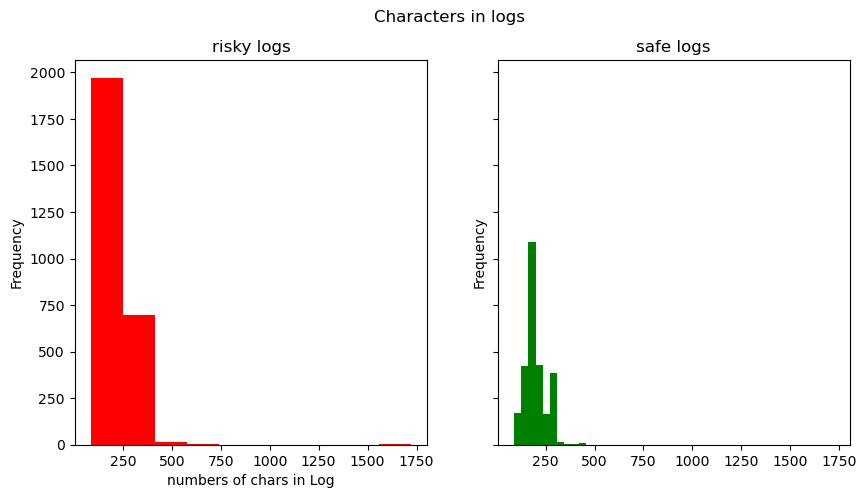

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
log_len=train_data_log_balanced[train_data_log_balanced['label']==1]['log_line'].str.len()
ax1.hist(log_len,color='red')
# Setting titles for the x-axis and y-axis in the first subplot
ax1.set_xlabel('numbers of chars in Log')
ax1.set_ylabel('Frequency') 
ax1.set_title('risky logs')
log_len=train_data_log_balanced[train_data_log_balanced['label']==0]['log_line'].str.len()
ax2.hist(log_len,color='green')
# Setting titles for the x-axis and y-axis in the first subplot
ax1.set_xlabel('numbers of chars in Log')
ax2.set_ylabel('Frequency') 
ax2.set_title('safe logs')
fig.suptitle('Characters in logs')
plt.show()


100 t0 300 characters in a log are the most common among both.

### Number of words in logs


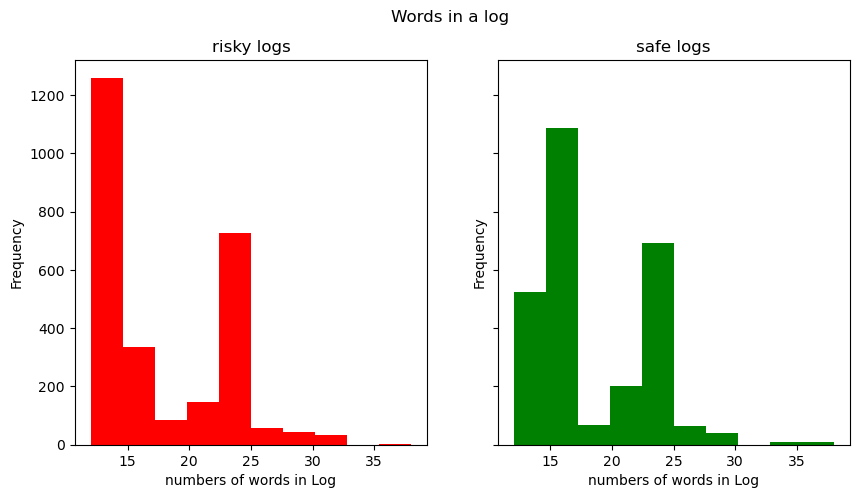

In [38]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
log_len=train_data_log_balanced[train_data_log_balanced['label']==1]['log_line'].str.split().map(lambda x: len(x))
ax1.hist(log_len,color='red')
# Setting titles for the x-axis and y-axis in the first subplot
ax1.set_xlabel('numbers of words in Log')
ax1.set_ylabel('Frequency') 
ax1.set_title('risky logs')
tweet_len=train_data_log_balanced[train_data_log_balanced['label']==0]['log_line'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
# Setting titles for the x-axis and y-axis in the first subplot
ax2.set_xlabel('numbers of words in Log')
ax2.set_ylabel('Frequency') 
ax2.set_title('safe logs')
fig.suptitle('Words in a log')
plt.show()


17 to 30 words in a log are the most common among both.

## Analyzing punctuation

In [39]:

# This function takes a label as input and creates a corpus by extracting words from log lines
def create_corpus_for_punctuation(label):
    # Initialize an empty list to store the words in the corpus.
    corpus = []
    # Iterate through log lines that correspond to the given label in the 'train_data_log_balanced' DataFrame.
    for log in train_data_log_balanced[train_data_log_balanced['label'] == label]['log_line'].str.split():
        # Iterate through each word in the log line and add it to the corpus.
        for word in log:
            corpus.append(word)
    return corpus


In [40]:
corpus_safe_for_punctuation=create_corpus_for_punctuation(0)

<BarContainer object of 2 artists>

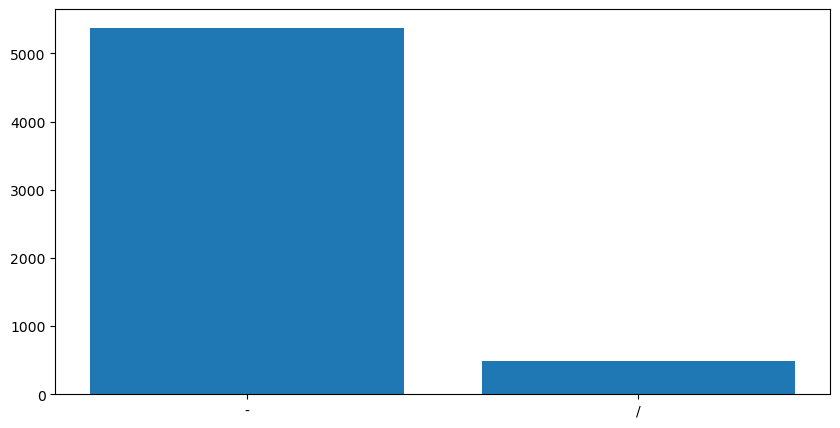

In [41]:
plt.figure(figsize=(10,5))
# Create a dictionary of word and its frequency in the corpus
dic=defaultdict(int)
special = string.punctuation
for word in (corpus_safe_for_punctuation):
    if word in special:
        dic[word]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

## See most common words using spacy

In [42]:
def create_corpus(label):
    # Separate each word in a log and append it to the corpus with default split (space)
    corpus = list(train_data_log_balanced[train_data_log_balanced['label'] == label]['log_line'])
    return corpus

In [43]:
corpus_safe = create_corpus(0)

In [44]:
nlp=spacy.load('en_core_web_sm')
## This is a simple example of how to use spacy to remove stop words and punctuation and create a new corpus
new_corpus=[]   
for doc in corpus_safe:
    remaining_tokens = []
    # Assuming you are using spaCy for natural language processing
    doc_tokens = nlp(doc)
    for token in doc_tokens:
        if token.is_stop or token.is_punct:
            continue
        remaining_tokens.append(token.text)
        new_corpus.append(remaining_tokens)

54.36.148.59 06 Jul/2021:00:51:26 -0700 /self.logs error.log.2018 04 03.gz HTTP/1.1 200 5971 Mozilla/5.0 compatible AhrefsBot/7.0 + http://ahrefs.com/robot/ 54.36.148.59 06 Jul/2021:00:51:26 -0700 /self.logs error.log.2018 04 03.gz HTTP/1.1 200 5971 Mozilla/5.0 compatible AhrefsBot/7.0 + http://ahrefs.com/robot/ 54.36.148.59 06 Jul/2021:00:51:26 -0700 /self.logs error.log.2018 04 03.gz HTTP/1.1 200 5971 Mozilla/5.0 compatible AhrefsBot/7.0 + http://ahrefs.com/robot/ 54.36.148.59 06 Jul/2021:00:51:26 -0700 /self.logs error.log.2018 04 03.gz HTTP/1.1 200 5971 Mozilla/5.0 compatible AhrefsBot/7.0 + http://ahrefs.com/robot/ 54.36.148.59 06 Jul/2021:00:51:26 -0700 /self.logs error.log.2018 04 03.gz HTTP/1.1 200 5971 Mozilla/5.0 compatible AhrefsBot/7.0 + http://ahrefs.com/robot/ 54.36.148.59 06 Jul/2021:00:51:26 -0700 /self.logs error.log.2018 04 03.gz HTTP/1.1 200 5971 Mozilla/5.0 compatible AhrefsBot/7.0 + http://ahrefs.com/robot/ 54.36.148.59 06 Jul/2021:00:51:26 -0700 /self.logs error.l

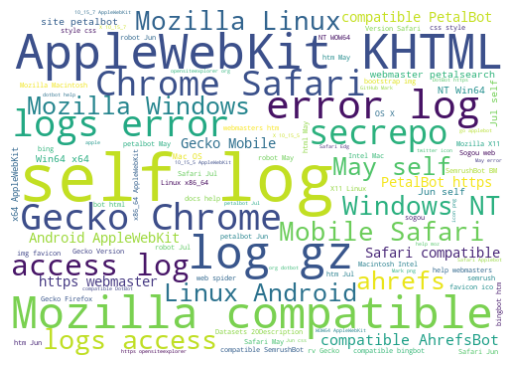

In [45]:

# Create stopword list
stopwords = set(STOPWORDS)

def plot_world_cloud (text):# Create and generate a word cloud image:
    wordcloud = WordCloud(width=500, height=350, stopwords=stopwords, max_words=100, background_color="white").generate(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
# get all log entries
text = " ".join(" ".join(entry) for entry in new_corpus)
print(text)
plot_world_cloud(text)